In [2]:
from __future__ import division
import time, os, gc
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction import text
import config

PATH = config.RAW_PATH

In [2]:
train_orig =  pd.read_csv(PATH+'train.csv', header=0)#.sample(n=10000)
test_orig =  pd.read_csv(PATH+'test.csv', header=0)#.sample(n=10000)

# def stem_str(x,stemmer=SnowballStemmer('english')):
#         x = text.re.sub("[^a-zA-Z0-9]"," ", x)
#         x = (" ").join([stemmer.stem(z) for z in x.split(" ")])
#         x = " ".join(x.split())
#         return x
# porter = PorterStemmer()
# snowball = SnowballStemmer('english')

# train_orig['question1'] = train_orig['question1'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
# train_orig['question1'] = train_orig['question1'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
# train_orig['question2'] = train_orig['question2'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
# train_orig['question2'] = train_orig['question2'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))

df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)
train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)


train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
# comb['q1_hash_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc))
# comb['q2_hash_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q2_vc))

comb['freq_diff'] = (abs(comb['q1_freq'] - comb['q2_freq'])+0.1) / (comb['q1_freq'] * comb['q2_freq'])

In [3]:
comb['q_hash_pos'] = comb['q1_hash']-comb['q2_hash']>0
comb['q_hash_pos'] = comb['q_hash_pos'].astype(int)
# comb['q_hash_pos_1'] = comb[['q1_freq','q_hash_pos']].apply(lambda x: 1 if x[0]>1 and x[1]>0 else 0, axis=1)

list1 = []
list1.append(0)
gpf = comb['q2_hash'].values
tag = gpf[0]
for i in range(comb.shape[0])[1:]:
    if gpf[i]-tag<0:
        list1.append(gpf[i]-tag)
    if gpf[i]-tag>=0:
        list1.append(gpf[i]-tag)
        tag=gpf[i]
comb['q2_change'] = list1

list1 = []
list1.append(0)
gpf = comb['q1_hash'].values
tag = gpf[0]
for i in range(comb.shape[0])[1:]:
    if gpf[i]-tag<0:
        list1.append(gpf[i]-tag)
    if gpf[i]-tag>=0:
        list1.append(gpf[i]-tag)
        tag=gpf[i]
comb['q1_change'] = list1

# comb['q1_q2_change_mean'] = (comb['q1_change'] + comb['q2_change'])/2.0
# comb['q1_q2_change_min'] = comb[['q1_change','q2_change']].apply(lambda x: min(x[0],x[1]),axis=1)
comb['q1_q2_change_max'] = comb[['q1_change','q2_change']].apply(lambda x: max(x[0],x[1]),axis=1)

Q_CHANGE = 0
comb['q_change_pair'] = (comb['q1_change']<Q_CHANGE) & (comb['q2_change']<Q_CHANGE)
comb['q_change_pair'] = comb['q_change_pair'].astype(int)
# comb['q_change_x'] = comb['q1_change'] * comb['q2_change']


In [4]:
from collections import defaultdict

# train_orig =  pd.read_csv(config.RAW_PATH+'train.csv', header=0)
# test_orig =  pd.read_csv(config.RAW_PATH+'test.csv', header=0)

ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])
        
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

def q1_q2_intersect_ratio(row):
    return len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']])))\
            / len(set(q_dict[row['question1']]).union(set(q_dict[row['question2']])))

comb['q1_q2_intersect'] = comb.apply(q1_q2_intersect, axis=1, raw=True)
# test_orig['q1_q2_intersect'] = test_orig.apply(q1_q2_intersect, axis=1, raw=True)
comb['q1_q2_intersect_ratio'] = comb.apply(q1_q2_intersect_ratio, axis=1, raw=True)
# test_orig['q1_q2_intersect_ratio'] = test_orig.apply(q1_q2_intersect_ratio, axis=1, raw=True)

In [5]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))
def word_match_share(q1, q2, stops=None):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1words = {}
    q2words = {}
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0.
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

q_dict = defaultdict(dict)
for i in range(ques.shape[0]):
        wm = word_match_share(ques.question1[i], ques.question2[i], stops=stops)
        q_dict[ques.question1[i]][ques.question2[i]] = wm
        q_dict[ques.question2[i]][ques.question1[i]] = wm

In [6]:
def q1_q2_wm_ratio(row):
    q1 = q_dict[row['question1']]
    q2 = q_dict[row['question2']]
    inter_keys = set(q1.keys()).intersection(set(q2.keys()))
    if(len(inter_keys) == 0): return 0.
    inter_wm = 0.
    total_wm = 0.
    for q,wm in q1.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    for q,wm in q2.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    if(total_wm == 0.): return 0.
    return inter_wm/total_wm


comb['q1_q2_wm_ratio'] = comb.apply(q1_q2_wm_ratio, axis=1, raw=True)

In [7]:
# train_comb = comb[comb['is_duplicate'] >= 0]#[corr_list]
# test_comb = comb[comb['is_duplicate'] < 0]#[corr_list]
comb[comb['is_duplicate'] >= 0].corr()

id  is_duplicate   q1_hash   q2_hash   q1_freq  \
id                     1.000000     -0.008784  0.692730  0.286969 -0.001608   
is_duplicate          -0.008784      1.000000 -0.206498 -0.349626  0.296621   
q1_hash                0.692730     -0.206498  1.000000  0.492993 -0.341777   
q2_hash                0.286969     -0.349626  0.492993  1.000000 -0.392605   
q1_freq               -0.001608      0.296621 -0.341777 -0.392605  1.000000   
q2_freq               -0.000777      0.198609 -0.202545 -0.466434  0.494315   
freq_diff              0.001553     -0.337501  0.093927  0.165365 -0.169080   
q_hash_pos             0.115864      0.123114  0.062609 -0.611694  0.120163   
q2_change             -0.181267     -0.354887  0.175287  0.889947 -0.402370   
q1_change             -0.355739     -0.258640  0.425403  0.280395 -0.443739   
q1_q2_change_max      -0.280031     -0.369709  0.362024  0.496426 -0.477415   
q_change_pair          0.169770      0.421856 -0.352406 -0.542355  0.485402   
q1_q2_intersect       -0.003347      0.412979 -0.316926 -0.464619  0.789134   
q1_q2_intersect_ratio -0.006791      0.609256 -0.339755 -0.526013  0.490514   
q1_q2_wm_ratio        -0.006519      0.641026 -0.344282 -0.540884  0.487466   

                        q2_freq  freq_diff  q_hash_pos  q2_change  q1_change  \
id                    -0.000777   0.001553    0.115864  -0.181267  -0.355739   
is_duplicate           0.198609  -0.337501    0.123114  -0.354887  -0.258640   
q1_hash               -0.202545   0.093927    0.062609   0.175287   0.425403   
q2_hash               -0.466434   0.165365   -0.611694   0.889947   0.280395   
q1_freq                0.494315  -0.169080    0.120163  -0.402370  -0.443739   
q2_freq                1.000000  -0.100777    0.277154  -0.478562  -0.263241   
freq_diff             -0.100777   1.000000    0.001560   0.169113   0.120852   
q_hash_pos             0.277154   0.001560    1.000000  -0.683733  -0.067113   
q2_change             -0.478562   0.169113   -0.683733   1.000000   0.456725   
q1_change             -0.263241   0.120852   -0.067113   0.456725   1.000000   
q1_q2_change_max      -0.359293   0.301276   -0.146369   0.642652   0.822861   
q_change_pair          0.370622  -0.353560    0.212361  -0.638353  -0.676821   
q1_q2_intersect        0.591368  -0.298225    0.162014  -0.475486  -0.409180   
q1_q2_intersect_ratio  0.358951  -0.428979    0.190019  -0.536898  -0.434685   
q1_q2_wm_ratio         0.355246  -0.444353    0.199713  -0.552301  -0.440957   

                       q1_q2_change_max  q_change_pair  q1_q2_intersect  \
id                            -0.280031       0.169770        -0.003347   
is_duplicate                  -0.369709       0.421856         0.412979   
q1_hash                        0.362024      -0.352406        -0.316926   
q2_hash                        0.496426      -0.542355        -0.464619   
q1_freq                       -0.477415       0.485402         0.789134   
q2_freq                       -0.359293       0.370622         0.591368   
freq_diff                      0.301276      -0.353560        -0.298225   
q_hash_pos                    -0.146369       0.212361         0.162014   
q2_change                      0.642652      -0.638353        -0.475486   
q1_change                      0.822861      -0.676821        -0.409180   
q1_q2_change_max               1.000000      -0.814393        -0.524993   
q_change_pair                 -0.814393       1.000000         0.527872   
q1_q2_intersect               -0.524993       0.527872         1.000000   
q1_q2_intersect_ratio         -0.558387       0.621898         0.722593   
q1_q2_wm_ratio                -0.564957       0.638566         0.684574   

                       q1_q2_intersect_ratio  q1_q2_wm_ratio  
id                                 -0.006791       -0.006519  
is_duplicate                        0.609256        0.641026  
q1_hash                            -0.339755       -0.344282  
q2_hash                       

In [8]:
comb.to_csv(config.FEAT_PATH+'magic_feature.csv',index=False)

In [4]:
# encoding: utf-8
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

import pandas as pd
import hashlib
import gc 

df_train = pd.read_csv(config.RAW_PATH+'train.csv').fillna("")
df_test = pd.read_csv(config.RAW_PATH+'test.csv').fillna("")


# Generating a graph of Questions and their neighbors
def generate_qid_graph_table(row):
    hash_key1 = hashlib.md5(row["question1"].encode('utf-8')).hexdigest()
    hash_key2 = hashlib.md5(row["question2"].encode('utf-8')).hexdigest()

    qid_graph.setdefault(hash_key1, []).append(hash_key2)
    qid_graph.setdefault(hash_key2, []).append(hash_key1)


qid_graph = {}
print('Apply to train...')
df_train.apply(generate_qid_graph_table, axis=1)
print('Apply to test...')
df_test.apply(generate_qid_graph_table, axis=1)


def pagerank():
    MAX_ITER = 20
    d = 0.85

    # Initializing -- every node gets a uniform value!
    pagerank_dict = {i: 1 / len(qid_graph) for i in qid_graph}
    num_nodes = len(pagerank_dict)

    for iter in range(0, MAX_ITER):

        for node in qid_graph:
            local_pr = 0

            for neighbor in qid_graph[node]:
                local_pr += pagerank_dict[neighbor] / len(qid_graph[neighbor])

            pagerank_dict[node] = (1 - d) / num_nodes + d * local_pr

    return pagerank_dict

print('Main PR generator...')
pagerank_dict = pagerank()

def get_pagerank_value(row):
    q1 = hashlib.md5(row["question1"].encode('utf-8')).hexdigest()
    q2 = hashlib.md5(row["question2"].encode('utf-8')).hexdigest()
    s = pd.Series({
        "q1_pr": pagerank_dict[q1],
        "q2_pr": pagerank_dict[q2]
    })
    return s

print('Apply to train...')
pagerank_feats_train = df_train.apply(get_pagerank_value, axis=1)
print('Writing train...')
# pagerank_feats_train.to_csv("pagerank_train.csv", index=False)
del df_train
gc.collect()
print('Apply to test...')
pagerank_feats_test = df_test.apply(get_pagerank_value, axis=1)
print('Writing test...')
# pagerank_feats_test.to_csv("pagerank_test.csv", index=False)


In [15]:
train = pd.concat([pagerank_feats_train, pagerank_feats_test], axis=0).reset_index(drop=True)
train.to_csv(config.FEAT_PATH+'pagerank.csv', index=False)

In [4]:
from tqdm import tqdm
import re

train_orig =  pd.read_csv(config.RAW_PATH+'train.csv', header=0)#.sample(n=1000)
test_orig =  pd.read_csv(config.RAW_PATH+'test.csv', header=0)#.sample(n=1000)
df = pd.concat([train_orig[['question1', 'question2']], 
                test_orig[['question1', 'question2']]], axis=0).reset_index(drop=True)
locations = pd.read_csv(config.FEAT_PATH+"cities.csv")
countries = set(locations['Country'].dropna(inplace=False).values.tolist())
all_places = countries
regex = "|".join(sorted(set(all_places)))



results = []
for index, row in tqdm(df.iterrows()):
    q1 = str(row['question1'])
    q2 = str(row['question2'])

    rr = {}

    q1_matches = []
    q2_matches = []

    if (len(q1) > 0):
        q1_matches = [i.lower() for i in re.findall(regex, q1, flags=re.IGNORECASE)]

    if (len(q2) > 0):
        q2_matches = [i.lower() for i in re.findall(regex, q2, flags=re.IGNORECASE)]

    rr['z_q1_place_num'] = len(q1_matches)
    rr['z_q1_has_place'] =len(q1_matches) > 0

    rr['z_q2_place_num'] = len(q2_matches) 
    rr['z_q2_has_place'] = len(q2_matches) > 0

    rr['z_place_match_num'] = len(set(q1_matches).intersection(set(q2_matches)))
    rr['z_place_match'] = rr['z_place_match_num'] > 0

    rr['z_place_mismatch_num'] = len(set(q1_matches).difference(set(q2_matches)))
    rr['z_place_mismatch'] = rr['z_place_mismatch_num'] > 0

    results.append(rr)     

loc_df = pd.DataFrame.from_dict(results)
#out_df.to_csv("../features/{}_place_matches.csv".format(dataset), index=False, header=True)
# out_df.to_csv("{}_place_matches.csv".format(dataset))

2750086it [16:42, 2744.08it/s]


In [5]:
magic_feature = pd.read_csv(config.FEAT_PATH+'magic_feature.csv')
pagerank = pd.read_csv(config.FEAT_PATH+'pagerank.csv')

magic_feature = pd.concat([magic_feature, pagerank, loc_df], axis=1)
magic_feature['z_place_match']=magic_feature['z_place_match'].astype(int)
magic_feature['z_place_mismatch']=magic_feature['z_place_mismatch'].astype(int)
magic_feature['z_q1_has_place']=magic_feature['z_q1_has_place'].astype(int)
magic_feature['z_q2_has_place']=magic_feature['z_q2_has_place'].astype(int)

In [39]:
train_orig =  pd.read_csv(config.RAW_PATH+'train.csv', header=0)#.sample(n=1000)
test_orig =  pd.read_csv(config.RAW_PATH+'test.csv', header=0)#.sample(n=1000)
df = pd.concat([train_orig[['question1', 'question2']], 
                test_orig[['question1', 'question2']]], axis=0).reset_index(drop=True)

question_kcores = pd.read_csv(config.FEAT_PATH+'question_kcores.csv')
question_kcores_dict = dict(zip(question_kcores.question, question_kcores.kcores))

def kcores(x):
    try:
        return question_kcores_dict[x.lower()]
    except: return -1
    
df['q1_kcores'] = df[['question1']].apply(lambda x: kcores(str(x['question1'])), axis=1)
df['q2_kcores'] = df[['question2']].apply(lambda x: kcores(str(x['question2'])), axis=1)
magic_feature[['q1_kcores','q2_kcores']] = df[['q1_kcores','q2_kcores']]


In [73]:
############ cliques networks ###########

%matplotlib inline
import networkx as nx
import pandas as pd
from itertools import combinations
import config

G = nx.Graph()
df = pd.read_csv(config.RAW_PATH+'train.csv',nrows=400000).fillna("")

edges = [tuple(x) for x in df[['question1', 'question2']].values]
G.add_edges_from(edges)

map_label = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'is_duplicate']].values)
map_clique_size = {}
cliques = sorted(list(nx.find_cliques(G)), key=lambda x: len(x))
for cli in cliques:
    for q1, q2 in combinations(cli, 2):
        if (q1, q2) in map_label:
            map_clique_size[q1, q2] = len(cli)
        elif (q2, q1) in map_label:
            map_clique_size[q2, q1] = len(cli)

df['clique_size'] = df.apply(lambda row: map_clique_size.get((row['question1'], row['question2']), -1), axis=1)

In [74]:
df[df['clique_size']>2]

id    qid1    qid2  \
12          12      25      26   
13          13      27      28   
14          14      29      30   
15          15      31      32   
18          18      37      38   
22          22      45      46   
29          29      59      60   
31          31      63      64   
38          38      77      78   
48          48      97      98   
49          49      99     100   
58          58     117     118   
62          62     125     126   
66          66     133     134   
67          67     135     136   
72          72     145     146   
73          73     147     148   
74          74     149     150   
79          79     159     160   
85          85     171     172   
86          86     173     174   
88          88     177     178   
92          92     185     186   
93          93     187     188   
100        100     201     202   
113        113     227     228   
118        118     237     238   
120        120     241     242   
123        123     247     248   
125        125     251     252   
...        ...     ...     ...   
399860  399860    6424  115673   
399862  399862    9350   59124   
399866  399866   29454  238380   
399867  399867   61005  128041   
399880  399880     489   56778   
399890  399890   13216    6275   
399891  399891  369519  141079   
399896  399896   67546   68125   
399900  399900    4629   22122   
399901  399901  118213   36478   
399914  399914   30820  415556   
399916  399916  354054  133020   
399930  399930  189036  138328   
399932  399932   40526   36872   
399933  399933   25909  123240   
399934  399934  153379   11099   
399936  399936  316892  344198   
399938  399938    4661   61683   
399941  399941  131205   50850   
399943  399943  122006   96191   
399956  399956  122282   70466   
399960  399960   86156  264174   
399967  399967   19307    9396   
399972  399972   25851  185894   
399973  399973  197647  131213   
399980  399980  178548  231588   
399986  399986   34642  251420   
399987  399987   54431    5294   
399990  399990  152363  299311   
399991  399991   38490   20771   

                                                question1  \
12                   What can make Physics easy to learn?   
13            What was your first sexual experience like?   
14      What are the laws to change your status from a...   
15      What would a Trump presidency mean for current...   
18      Why are so many Quora users posting questions ...   
22        What are the questions should not ask on Quora?   
29                 How should I prepare for CA final law?   
31      What are some special cares for someone with a...   
38                            How do we prepare for UPSC?   
48      What are some examples of products that can be...   
49                                 How do I make friends.   
58      I was suddenly logged off Gmail. I can't remem...   
62      How is the new Harry Potter book 'Harry Potter...   
66                       What is the best book ever made?   
67        Can we ever store energy produced in lightning?   
72                      How I can speak English fluently?   
73      How helpful is QuickBooks' auto data recovery ...   
74      Who is the richest gambler of all time and how...   
79                               What is purpose of life?   
85            How can I increase my height after 21 also?   
86      What were the major effects of the cambodia ea...   
88         Which is the best gaming laptop under 60k INR?   
92      What are some of the best romantic movies in E...   
93                               What causes a nightmare?   
100     Will there really be any war between India and...   
113                         What do you think China food?   
118     What are some mind-blowing computer tools that...   
120     Why my question was marked as needing imrovement?   
123         What is the greatest mystery in the universe?   
125     Why does China block sanctions at the UN again...   
...         

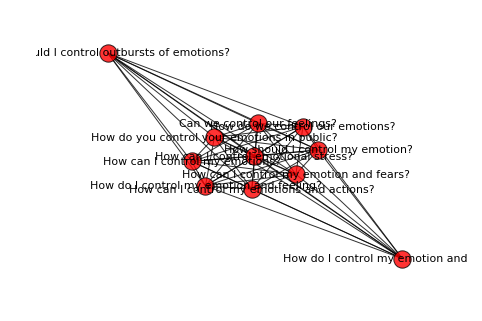

In [77]:
import networkx as nx
import random

cliques = nx.find_cliques(G)
cliques = [clq for clq in cliques if len(clq) >= 6]

h = G.subgraph([n for n in random.choice(cliques)])
nx.draw(h, with_labels=True, alpha=0.8, font_size=11)
# break